In [35]:
from tensorflow import keras
from tensorflow.keras import layers
import os, pathlib
from keras.preprocessing.image import ImageDataGenerator

In [36]:
# Check classes in directory (3 classes with highest number of images are kept as per instruction and rest are deleted)
directory = pathlib.Path("./birds_species/train")
directory_length = len(os.listdir("./birds_species/train"))
print("Total number of classes in directory are ", directory_length)

Total number of classes in directory are  3


In [37]:
# Check classes names of directory
for item in directory.glob("*"):
    print(item.name)

D-ARNAUDS BARBET
HOUSE FINCH
RUFOUS TREPE


In [52]:
# Define data argument
data_augmentation_train = ImageDataGenerator(
    rescale = 1.0 / 255,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)
data_augmentation = ImageDataGenerator(rescale = 1.0 / 255)


In [70]:
# Transfer data from directories to batches and resize images
train_dataset = data_augmentation_train.flow_from_directory(
    "./birds_species/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode = 'categorical')
validation_dataset = data_augmentation_train.flow_from_directory(
    "./birds_species/valid",
    target_size=(244, 244),
    batch_size=32)
test_dataset = data_augmentation.flow_from_directory(
    "./birds_species/test",
    target_size=(244, 244),
    batch_size=32)

Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [71]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3))

In [72]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [80]:
inputs = keras.Input(shape=(244, 244, 3))
x = inputs
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [81]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 244, 244, 3)]     0         
                                                                 
 tf.__operators__.getitem_8   (None, 244, 244, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_8 (TFOpLambd  (None, 244, 244, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                          

In [82]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset)

Epoch 1/10
24/24 [==============================] - 55s 2s/step - loss: 1.7607 - accuracy: 0.3333 - val_loss: 1.1023 - val_accuracy: 0.3333
Epoch 2/10
24/24 [==============================] - 60s 2s/step - loss: 1.5125 - accuracy: 0.3589 - val_loss: 1.1484 - val_accuracy: 0.3333
Epoch 3/10
24/24 [==============================] - 61s 3s/step - loss: 1.3860 - accuracy: 0.3387 - val_loss: 1.1032 - val_accuracy: 0.5333
Epoch 4/10
24/24 [==============================] - 61s 3s/step - loss: 1.2972 - accuracy: 0.3548 - val_loss: 1.1484 - val_accuracy: 0.3333
Epoch 5/10
24/24 [==============================] - 62s 3s/step - loss: 1.1930 - accuracy: 0.3656 - val_loss: 1.1231 - val_accuracy: 0.3333
Epoch 6/10
24/24 [==============================] - 63s 3s/step - loss: 1.1636 - accuracy: 0.3777 - val_loss: 1.0878 - val_accuracy: 0.4000
Epoch 7/10
24/24 [==============================] - 65s 3s/step - loss: 1.1601 - accuracy: 0.3468 - val_loss: 1.0833 - val_accuracy: 0.3333
Epoch 8/10
24/24 [==

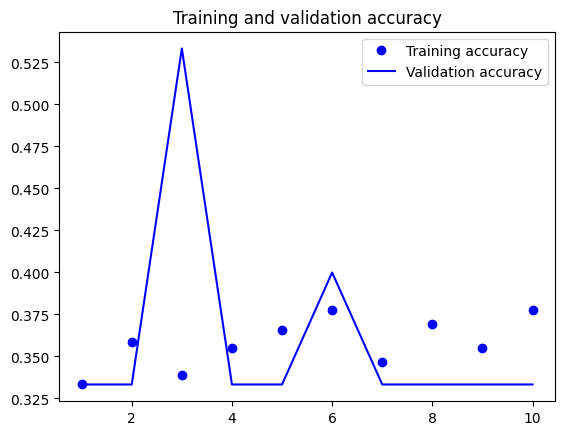

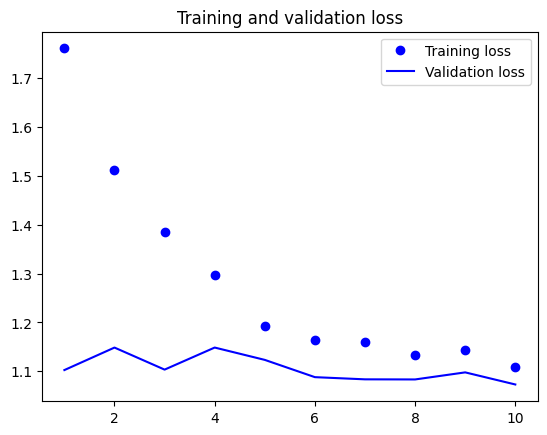

In [83]:
# Visualize the results
from matplotlib import pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [84]:
model = keras.models.load_model("./models/fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 1s 1s/step - loss: 1.0991 - accuracy: 0.3333
Test accuracy: 0.333


In [85]:
# Predict on test data
import numpy as np
test_predictions = model.predict(test_dataset)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = test_dataset.classes

1/1 [==============================] - 1s 1s/step


In [129]:
# Calculate accuracy, confusion matrix, precision, recall, F1-score

import tensorflow as tf
accuracy = np.mean(test_true_classes == np.argmax(test_predictions, axis=1))
precision, recall, _  = tf.math.confusion_matrix(test_true_classes, test_pred_classes)

In [88]:
accuracy

0.3333333333333333

In [130]:
precision

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 0, 5])>

In [132]:
recall

tf.Tensor([0 0 5], shape=(3,), dtype=int32)


In [128]:
incorrects = np.where( test_pred_classes != test_true_classes)[0]
print("number of incorrect predictions: ", len(incorrects))

number of incorrect predictions:  10
